<a href="https://www.kaggle.com/code/muhammadmeftahmafazy/classification?scriptVersionId=129158386" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mengimpor *Library*

In [328]:
# feature extractoring and preprocessing data
import librosa
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc, plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC

#Pytorch
import torch

from imblearn.pipeline import Pipeline

import joblib

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Other
from IPython.display import Audio
from tqdm import tqdm

# Inisial Dataset

In [329]:
#Panggil Dataset
data = pd.read_csv("../input/coughvid-19/dataset/data_mfcc30.csv")

In [330]:
#Menghapus kolom nama file
data_new = data.drop('filename', axis=1)

In [331]:
#Mengubah label menjadi numerik
data_new['label'].replace(['healthy', 'COVID-19'], [0,1], inplace=True)

In [332]:
# memisahkan atribut pada dataset dan menyimpannya pada sebuah variabel. 
# array ke-16 untuk dataset 10 mfcc
# array ke-26 untuk dataset 20 mfcc
# array ke-36 untuk dataset 30 mfcc
X = data_new[data_new.columns[:36]]

# memisahkan label pada dataset dan menyimpannya pada sebuah variabel
y = data_new['label']

# Klasifikasi menggunakan *SVM* dengan Stratified K-Fold

In [333]:
# standarisasi nilai-nilai dari dataset
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [334]:
# Inisialisasi objek stratified k-fold dengan inisial skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [335]:
# # Loop untuk setiap fold pada data
# for train_index, test_index in skf.split(X, y):
#     # Memisahkan data untuk training dan testing
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# Mencari Parameter Terbaik menggunakan algoritma GridSearchCV

In [336]:
# # Mencari parameter terbaik menggunakan Grid Search
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
#               'gamma': [0.01, 0.1, 1, 10, 100], 
#               'kernel': ['rbf'],
#              }

# clf = GridSearchCV(SVC(), param_grid, cv=skf, scoring='roc_auc')
# clf.fit(X_train_scaled, y_train)

# # Menampilkan parameter terbaik dan AUC pada data testing
# y_pred = clf.decision_function(X_test_scaled)
# auc = roc_auc_score(y_test, y_pred)

# print("Best parameters: ", clf.best_params_)
# print("AUC on test set: ", auc)

In [337]:
    # Loop untuk setiap fold pada data
    for train_index, test_index in skf.split(X, y):
        # Memisahkan data untuk training dan testing
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # # Inisialisasi objek SVM
    # clf = SVC(kernel='rbf')
    clf = SVC (kernel='rbf', C=1, gamma='scale', probability=True )
    # clf = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

    # Melakukan training pada model SVM
    clf.fit(X_train, y_train)

    # Melakukan prediksi pada data testing
    y_pred = clf.predict(X_test)

    # Hitung Probabilitas
    y_prob = clf.decision_function(X_test)

In [338]:
# # Mengetahui jumlah data training dan data testing
print(len(X_train))
print(len(X_test))
print("training",pd.value_counts(y_train))
print("testing",pd.value_counts(y_test))

1734
192
training 0    1156
1     578
Name: label, dtype: int64
testing 0    128
1     64
Name: label, dtype: int64


In [339]:
# Menampilkan Akurasi data training dan data testing
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.7561
Test set score: 0.6979


# Confusion Matrix

Confusion matrix

 [[125   3]
 [ 55   9]]

True Positives(TP) =  9

True Negatives(TN) =  125

False Positives(FP) =  3

False Negatives(FN) =  55


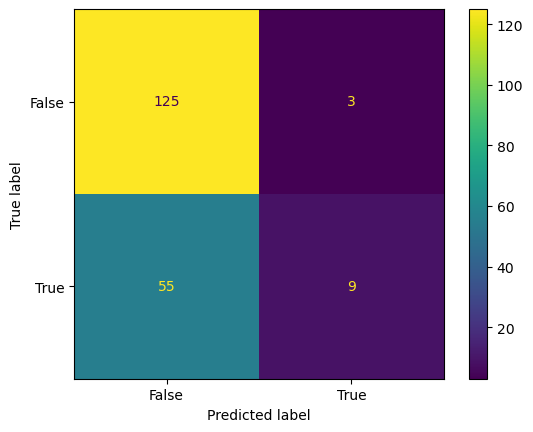

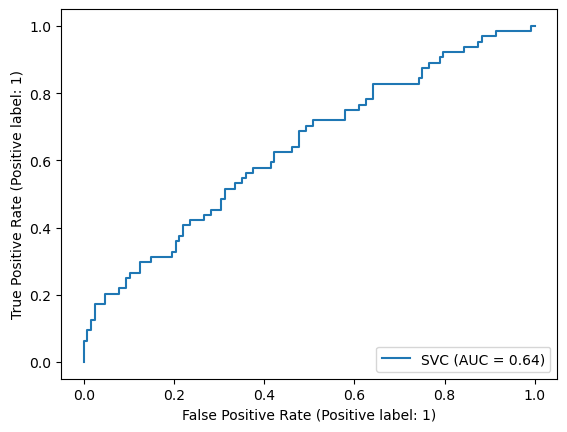

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.697917       0.75            0.140625     0.976562  0.637085


In [340]:
    # Confusion Matrix
    results = []
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n\n',  confusion_matrix)

    print('\nTrue Positives(TP) = ',  confusion_matrix[1,1])

    print('\nTrue Negatives(TN) = ',  confusion_matrix[0,0])

    print('\nFalse Positives(FP) = ',  confusion_matrix[0,1])

    print('\nFalse Negatives(FN) = ',  confusion_matrix[1,0])

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
     
    Accuracy = metrics.accuracy_score(y_test, y_pred)
    Precision = metrics.precision_score(y_test, y_pred)
    Sensitivity_recall = metrics.recall_score(y_test, y_pred)
    Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)

#     print(classification_report(y_test, y_pred))
    plot_roc_curve(clf, X_test, y_test)
    plt.show()
    
    # AUC (y_prob[:,1] khusus untuk random forest dan knn)
    auc = roc_auc_score(y_test, y_prob)
    
     # Simpan hasil ke dalam list
    results.append({'Accuracy': Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity, 'AUC':auc})
    
    # Buat dataframe dari hasil
    df = pd.DataFrame(results)

    # Print dataframe
    print(df)

In [341]:
    # Confusion Matrix
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81       128
           1       0.75      0.14      0.24        64

    accuracy                           0.70       192
   macro avg       0.72      0.56      0.52       192
weighted avg       0.71      0.70      0.62       192

